In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf

import keras
from tensorflow.keras import layers, models
import numpy as np
import musdb
import random
import librosa
import museval
import soundfile as sf
import matplotlib.pyplot as plt
from IPython.display import Audio

## Duomenų paruošimas

In [3]:
mus_train = musdb.DB(root='/musdb', is_wav=True, subsets='train', split='train')
mus_valid = musdb.DB(root='/musdb', is_wav=True, subsets='train', split='valid')

def train_gen():
    for track in mus_train:
        mixture = librosa.to_mono(track.audio.T)
        vocals = librosa.to_mono(track.targets['vocals'].audio.T)
        mixture_frames = tf.signal.frame(mixture, 262144, 262144, axis=0, pad_end=True).numpy()
        vocals_frames = tf.signal.frame(vocals, 262144, 262144, axis=0, pad_end=True).numpy()
        for mixture_frame, vocals_frame in zip(mixture_frames, vocals_frames):
            semitones_to_shift = random.randint(-6, 6)
            mixture_frame = librosa.effects.pitch_shift(mixture_frame, sr = 44100, n_steps = semitones_to_shift)
            vocals_frame = librosa.effects.pitch_shift(vocals_frame, sr = 44100, n_steps = semitones_to_shift)
            mixture_ft = librosa.stft(mixture_frame)
            vocals_ft = librosa.stft(vocals_frame)

            mag_mixture = np.abs(mixture_ft)
            mag_vocals = np.abs(vocals_ft)

            mask_vocals = mag_vocals / (np.maximum(mag_vocals, mag_mixture) + 1e-8)

            mixture_ft = mixture_ft[:1024, :512]
            mask_vocals = mask_vocals[:1024, :512]

            mixture_ft = tf.convert_to_tensor(np.real(mixture_ft), dtype=tf.float32)
            phase_mixture = tf.convert_to_tensor(np.imag(mixture_ft), dtype=tf.float32)
            mask_vocals = tf.convert_to_tensor(mask_vocals, dtype=tf.float32)

            input_data = tf.stack([mixture_ft, phase_mixture], axis=-1)

            yield input_data, np.reshape(mask_vocals, (mask_vocals.shape[0], mask_vocals.shape[1], 1))
    return

def valid_gen():
    for track in mus_valid:
        mixture = librosa.to_mono(track.audio.T)
        vocals = librosa.to_mono(track.targets['vocals'].audio.T)
        mixture_frames = tf.signal.frame(mixture, 262144, 262144, axis=0, pad_end=True).numpy()
        vocals_frames = tf.signal.frame(vocals, 262144, 262144, axis=0, pad_end=True).numpy()
        for mixture_frame, vocals_frame in zip(mixture_frames, vocals_frames):
            semitones_to_shift = random.randint(-6, 6)
            mixture_frame = librosa.effects.pitch_shift(mixture_frame, sr = 44100, n_steps = semitones_to_shift)
            vocals_frame = librosa.effects.pitch_shift(vocals_frame, sr = 44100, n_steps = semitones_to_shift)
            mixture_ft = librosa.stft(mixture_frame)
            vocals_ft = librosa.stft(vocals_frame)

            mag_mixture = np.abs(mixture_ft)
            mag_vocals = np.abs(vocals_ft)

            mask_vocals = mag_vocals / (np.maximum(mag_vocals, mag_mixture) + 1e-8)

            mixture_ft = mixture_ft[:1024, :512]
            mask_vocals = mask_vocals[:1024, :512]

            mixture_ft = tf.convert_to_tensor(np.real(mixture_ft), dtype=tf.float32)
            phase_mixture = tf.convert_to_tensor(np.imag(mixture_ft), dtype=tf.float32)
            mask_vocals = tf.convert_to_tensor(mask_vocals, dtype=tf.float32)

            input_data = tf.stack([mixture_ft, phase_mixture], axis=-1)

            yield input_data, np.reshape(mask_vocals, (mask_vocals.shape[0], mask_vocals.shape[1], 1))
    return

batch_size = 16
output_signature = (
    tf.TensorSpec(shape=(1024, 512, 2), dtype=tf.float32),
    tf.TensorSpec(shape=(1024, 512, 1), dtype=tf.float32)
)

with tf.device("CPU"):
    ds_train = tf.data.Dataset.from_generator(train_gen, output_signature=output_signature)
    ds_train = ds_train.cache()
    ds_train = ds_train.shuffle(buffer_size=1024)
    ds_train = ds_train.batch(batch_size)
    ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
    ds_train = ds_train.repeat(1)
    
    ds_valid = tf.data.Dataset.from_generator(valid_gen, output_signature=output_signature)
    ds_valid = ds_valid.batch(batch_size)
    ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)
    ds_valid = ds_valid.repeat(1)


## Konvoliucinis neuroninis tinklas

In [4]:
input_layer = tf.keras.layers.Input(shape=(1024, 512, 2))

conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
conv1 = tf.keras.layers.GroupNormalization()(conv1)
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = tf.keras.layers.GroupNormalization()(conv1)
conv1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = tf.keras.layers.GroupNormalization()(conv1)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv1)

conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
conv2 = tf.keras.layers.GroupNormalization()(conv2)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = tf.keras.layers.GroupNormalization()(conv2)
conv2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = tf.keras.layers.GroupNormalization()(conv2)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv2)

conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = tf.keras.layers.GroupNormalization()(conv3)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = tf.keras.layers.GroupNormalization()(conv3)
conv3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = tf.keras.layers.GroupNormalization()(conv3)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv3)

conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
conv4 = tf.keras.layers.GroupNormalization()(conv4)
conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = tf.keras.layers.GroupNormalization()(conv4)
conv4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
conv4 = tf.keras.layers.GroupNormalization()(conv4)
pool4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(conv4)

conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
conv5 = tf.keras.layers.GroupNormalization()(conv5)
conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = tf.keras.layers.GroupNormalization()(conv5)
conv5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
conv5 = tf.keras.layers.GroupNormalization()(conv5)

up6 = tf.keras.layers.UpSampling2D(size=(2, 2))(conv5)
up6 = tf.keras.layers.Concatenate()([conv4, up6])
up6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
up6 = tf.keras.layers.GroupNormalization()(up6)
up6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
up6 = tf.keras.layers.GroupNormalization()(up6)
up6 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
up6 = tf.keras.layers.GroupNormalization()(up6)

up7 = tf.keras.layers.UpSampling2D(size=(2, 2))(up6)
up7 = tf.keras.layers.Concatenate()([conv3, up7])
up7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
up7 = tf.keras.layers.GroupNormalization()(up7)
up7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
up7 = tf.keras.layers.GroupNormalization()(up7)
up7 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
up7 = tf.keras.layers.GroupNormalization()(up7)

up8 = tf.keras.layers.UpSampling2D(size=(2, 2))(up7)
up8 = tf.keras.layers.Concatenate()([conv2, up8])
up8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
up8 = tf.keras.layers.GroupNormalization()(up8)
up8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
up8 = tf.keras.layers.GroupNormalization()(up8)
up8 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
up8 = tf.keras.layers.GroupNormalization()(up8)

up9 = tf.keras.layers.UpSampling2D(size=(2, 2))(up8)
up9 = tf.keras.layers.Concatenate()([conv1, up9])
up9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
up9 = tf.keras.layers.GroupNormalization()(up9)
up9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
up9 = tf.keras.layers.GroupNormalization()(up9)
up9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
up9 = tf.keras.layers.GroupNormalization()(up9)

x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(up9)

model_cnn = tf.keras.Model(inputs=input_layer, outputs=x)

In [26]:
model_cnn.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 1024, 512, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 1024, 512, │        608 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 1024, 512, │         64 │ conv2d_84[0][0]   │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 1024, 512, │      9,248 │ group_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 1024, 512, │         64 │ conv2d_85[0][0]   │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_86 (Conv2D)  │ (None, 1024, 512, │      9,248 │ group_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 1024, 512, │         64 │ conv2d_86[0][0]   │
│ (GroupNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 512, 256,  │          0 │ group_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_87 (Conv2D)  │ (None, 512, 256,  │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 512, 256,  │        128 │ conv2d_87[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_88 (Conv2D)  │ (None, 512, 256,  │     36,928 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 512, 256,  │        128 │ conv2d_88[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_89 (Conv2D)  │ (None, 512, 256,  │     36,928 │ group_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 512, 256,  │        128 │ conv2d_89[0][0]   │
│ (GroupNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 256, 128,  │          0 │ group_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_90 (Conv2D)  │ (None, 256, 128,  │     73,856 │ max_pooling2d_13… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ group_normalizatio… │ (None, 256, 128,  │        256 │ conv2d_90[0][0] 

 Total params: 11,782,689 (44.95 MB)

 Trainable params: 11,782,689 (44.95 MB)

 Non-trainable params: 0 (0.00 B)

### Pirmas mokymas

In [5]:
loss_fn = tf.keras.losses.MeanSquaredError()
initial_learning_rate = 0.003

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.5
    else:
        return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

model_cnn.compile(optimizer=optimizer, loss=loss_fn, metrics=['mae'])

In [ ]:
history = model_cnn.fit(ds_train, epochs=30, callbacks=[callback], validation_data = ds_valid)

In [7]:
model_cnn.save('model_cnn.keras')

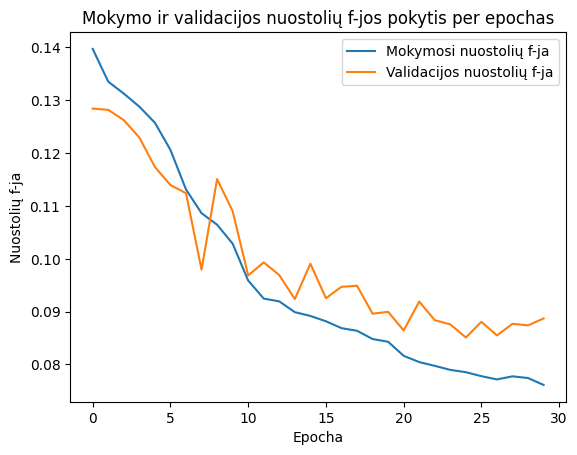

In [8]:
plt.plot(history.history['loss'], label='Mokymosi nuostolių f-ja')
plt.plot(history.history['val_loss'], label='Validacijos nuostolių f-ja')
plt.xlabel('Epocha')
plt.ylabel('Nuostolių f-ja')
plt.title('Mokymo ir validacijos nuostolių f-jos pokytis per epochas')
plt.legend()
plt.show()

## Transformerių neuroninis tinklas

In [4]:
keras.saving.get_custom_objects().clear()

@keras.saving.register_keras_serializable()
class ImageToPatches(layers.Layer):
    def __init__(self, patch_size):
        super(ImageToPatches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dim = patches.shape[-1]
        num_patches = patches.shape[1] * patches.shape[2]
        batch_size = tf.shape(patches)[0]
        patches = tf.reshape(patches, [batch_size, num_patches, patch_dim])
        return patches

    def get_config(self):
        return {"patch_size": self.patch_size}

@keras.saving.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.proj = None

    def build(self, input_shape):
        self.proj = layers.Dense(self.embed_dim)
        super(PatchEmbedding, self).build(input_shape)
    
    def call(self, patch):
        return self.proj(patch)

    def get_config(self):
        return {
            "embed_dim": self.embed_dim,
        }

    @classmethod
    def from_config(cls, config):
        return cls(**config)

@keras.saving.register_keras_serializable()
class PositionalEmbedding(layers.Layer):
    def __init__(self, embed_dim):
        super(PositionalEmbedding, self).__init__()
        self.embed_dim = embed_dim

    def build(self, input_shape):
        num_patches = input_shape[1]
        self.pos_embed = self.add_weight(name="pos_embed", shape=(1, num_patches, self.embed_dim), initializer='uniform')

    def call(self, patch):
        return patch + self.pos_embed

    def get_config(self):
        return {"embed_dim": self.embed_dim}

@keras.saving.register_keras_serializable()
class ReshapeLayer(layers.Layer):
    def __init__(self, output_shape, **kwargs):
        super(ReshapeLayer, self).__init__(**kwargs)
        self.output_shape = output_shape

    def call(self, inputs):
        return tf.reshape(inputs, self.output_shape)

    def get_config(self):
        return {"output_shape": self.output_shape}

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dense(inputs.shape[-1])(x)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    return x + res

def build_vit_segmentation_model(input_shape, patch_size, embed_dim, num_heads, ff_dim, num_transformer_blocks, num_classes, dropout=0):
    inputs = layers.Input(shape=input_shape)
        
    patches = ImageToPatches(patch_size)(inputs)
    
    x = PatchEmbedding(embed_dim)(patches)

    x = PositionalEmbedding(embed_dim)(x)

    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, embed_dim, num_heads, ff_dim, dropout)

    x = layers.Dense(patch_size * patch_size * num_classes)(x)

    x = ReshapeLayer(output_shape=[-1, input_shape[0], input_shape[1], num_classes])(x)
    
    x = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(x)
    return models.Model(inputs, x)

input_shape = (1024, 512, 2)
model_t = build_vit_segmentation_model(
    input_shape=input_shape,
    patch_size=16,
    embed_dim=512,
    num_heads=4,
    ff_dim=512,
    num_transformer_blocks=4,
    num_classes=1,
    dropout=0.1
)

In [40]:
model_t.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1024, 512, │          0 │ -                 │
│ (InputLayer)        │ 2)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_to_patches_1  │ (None, 2048, 512) │          0 │ input_layer[0][0] │
│ (ImageToPatches)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding_1   │ (None, 2048, 512) │    262,656 │ image_to_patches… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 2048, 512) │  1,048,576 │ patch_embedding_… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2048, 512) │  4,200,960 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 2048, 512) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 2048, 512) │      1,024 │ dropout_5[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 2048, 512) │          0 │ layer_normalizat… │
│                     │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2048, 512) │    262,656 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 2048, 512) │    262,656 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 2048, 512) │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2048, 512) │      1,024 │ dropout_6[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 2048, 512) │          0 │ layer_normalizat… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 2048, 512) │  4,200,960 │ add_1[0][0],      │
│ (MultiHeadAttentio… │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 2048, 512) │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 2048, 512) │      1,024 │ dropout_8[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 2048, 512) │          0 │ layer_normalizat… │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048, 512) │    262,656 │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2048, 512) │    262,656 │ dense_4[0][0]   

 Total params: 20,355,842 (77.65 MB)

 Trainable params: 20,355,842 (77.65 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
loss_fn = tf.keras.losses.MeanSquaredError()
initial_learning_rate = 0.0003

def lr_schedule(epoch, lr):
    if epoch % 10 == 0 and epoch != 0:
        return lr * 0.8
    else:
        return lr

optimizer = tf.keras.optimizers.Adam(learning_rate=initial_learning_rate)
callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

model_t.compile(optimizer=optimizer, loss=loss_fn, metrics=['mae'])

In [ ]:
history_t = model_t.fit(ds_train, epochs=20, callbacks=[callback], validation_data = ds_valid)

In [7]:
model_t.save('model_t.keras')

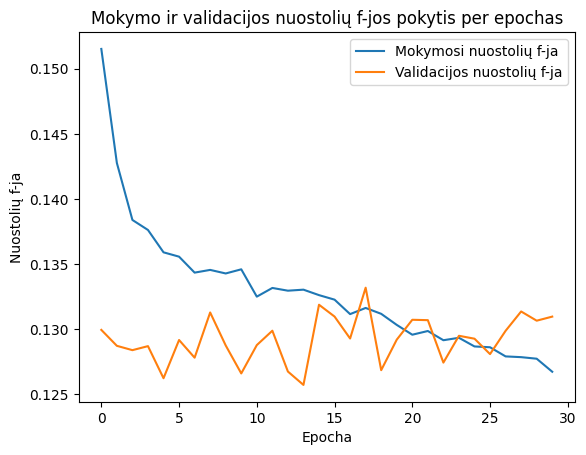

In [44]:
plt.plot(history_t.history['loss'], label='Mokymosi nuostolių f-ja')
plt.plot(history_t.history['val_loss'], label='Validacijos nuostolių f-ja')
plt.xlabel('Epocha')
plt.ylabel('Nuostolių f-ja')
plt.title('Mokymo ir validacijos nuostolių f-jos pokytis per epochas')
plt.legend()
plt.show()

## Rezultatų skaičiavimas

In [36]:
tf.keras.backend.clear_session()

In [9]:
mus_test = musdb.DB(root='/musdb', is_wav=True, subsets='test')

In [10]:
model_cnn = tf.keras.models.load_model('model_cnn.keras')

In [11]:
model_t = tf.keras.models.load_model('model_t.keras')

In [12]:
def process_audio_frame(audio_frame_ft):
    phase = np.angle(audio_frame_ft)
    audio_frame_ft = audio_frame_ft[:1024, :512]
    phase = phase[:1024, :512]
    audio_frame_ft = tf.convert_to_tensor(np.real(audio_frame_ft), dtype=tf.float32)
    phase = tf.convert_to_tensor(phase, dtype=tf.float32)
    input_tensor = tf.stack([audio_frame_ft, phase], axis=-1)
    return input_tensor

def get_audio_signal(predicted_masks, audio_frames):
    predicted_audio = []
    for predicted_mask, audio_frame in zip(predicted_masks, audio_frames):        
        mask = np.pad(np.squeeze(predicted_mask), ((0, 1), (0, 1)), mode='constant')
        mix_magnitude, mix_phase = np.abs(audio_frame), np.angle(audio_frame)
        src_magnitude = mix_magnitude * mask
        src_stft = src_magnitude * np.exp(1j * mix_phase)
        result = librosa.istft(src_stft)
    
        predicted_audio = np.append(predicted_audio, result)
    return predicted_audio

def predict_signal_for_mono_audio(audio, model, device):
    audio_frames = tf.signal.frame(audio, 262144, 262144, axis=0, pad_end=True).numpy()
    audio_frames_ft = np.array(list(map(librosa.stft, audio_frames)))
    
    audio_inputs = np.array(list(map(process_audio_frame, audio_frames_ft)))
    with tf.device(device):
        predicted_masks = model.predict(audio_inputs, batch_size=16)
    predicted_signal = get_audio_signal(predicted_masks, audio_frames_ft)
    return predicted_signal

def calcutale_SDR_for_dataset(data, model, log=False, results_dir=None, device="GPU", save_audio=False, audio_folder=None):
    if audio_folder != None and not os.path.exists(audio_folder):
        os.makedirs(audio_folder)
    results = museval.EvalStore(frames_agg='median', tracks_agg='median')
    for track in data:
        track_name = track.name
        if log == True:
            print(f"Calculating SDR for song: {track_name}")
        audio_stereo = track.audio.T
        vocals_gt = track.targets['vocals'].audio.T
        predicted_vocals = np.array(list(map(lambda audio: predict_signal_for_mono_audio(audio, model, device), audio_stereo)))
        vocals_shape = vocals_gt.shape
        predicted_shape = predicted_vocals.shape
        length_to_trim = predicted_shape[1] - vocals_shape[1]
        predicted_vocals = predicted_vocals[:, :predicted_shape[1] - length_to_trim]
        predicted_acc = audio_stereo - predicted_vocals
        
        if save_audio == True and audio_folder != None:
            print('Saving audio at: ' + audio_folder + track_name +'.wav')
            predicted_vocals_to_write = predicted_vocals.T
            sf.write(audio_folder + track_name +'.wav', predicted_vocals_to_write, 44100, subtype='PCM_24')
        estimates = {
            'vocals': predicted_vocals.T,
            'accompaniment': predicted_acc.T
        }
        scores = museval.eval_mus_track(
            track, estimates, output_dir=results_dir
        )
        results.add_track(scores)
        if log == True:
            print(scores)
    return results

def save_predicted_audio_for_musdb_track(track, model, directory, device="GPU"):
    audio_stereo = track.audio.T
    predicted_vocals = np.array(list(map(lambda audio: predict_signal_for_mono_audio(audio, model, device), audio_stereo)))
    audio_shape = audio_stereo.shape
    predicted_shape = predicted_vocals.shape
    length_to_trim = predicted_shape[1] - audio_shape[1]
    predicted_vocals = predicted_vocals[:, :predicted_shape[1] - length_to_trim]
    if not os.path.exists(directory):
        os.makedirs(directory)
    sf.write(directory + track.name +'.wav', predicted_vocals.T, 44100, subtype='PCM_24')

In [13]:
results = calcutale_SDR_for_dataset(mus_test, model_cnn, log=True, results_dir="/results", device="GPU", save_audio=True, audio_folder="/results/audio/")

Calculating SDR for song: AM Contra - Heart Peripheral


2024-05-21 08:51:14.125219: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[16,32,1024,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,1024,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-05-21 08:51:14.262672: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.137639918s
Trying algorithm eng0{} for conv (f32[16,32,1024,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,96,1024,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0

3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
Saving audio at: /results/audio/AM Contra - Heart Peripheral.wav
vocals          ==> SDR:   2.843  SIR:   5.888  ISR:   4.595  SAR:   4.667  
accompaniment   ==> SDR:   9.216  SIR:   9.657  ISR:  19.583  SAR:  18.536  

Calculating SDR for song: Al James - Schoolboy Facination
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 240ms/step
Saving audio at: /results/audio/Al James - Schoolboy Facination.wav
vocals          ==> SDR:   3.441  SIR:   5.137  ISR:   5.310  SAR:   6.725  
accompaniment   ==> SDR:   5.094  SIR:   4.748  ISR:  12.917  SAR:  13.260  

Calculating SDR for song: Angels In Amplifiers - I'm Alright
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step

2024-05-21 09:06:22.097963: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[15,32,1024,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,96,1024,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0}} is taking a while...
2024-05-21 09:06:22.138115: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.04033226s
Trying algorithm eng0{} for conv (f32[15,32,1024,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[15,96,1024,512]{3,2,1,0}, f32[32,96,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0"

2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 24s/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
Saving audio at: /results/audio/Angels In Amplifiers - I'm Alright.wav
vocals          ==> SDR:   3.378  SIR:   4.443  ISR:   5.909  SAR:   6.261  
accompaniment   ==> SDR:   7.217  SIR:   7.794  ISR:  13.375  SAR:  13.206  

Calculating SDR for song: Arise - Run Run Run
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 245ms/step
Saving audio at: /results/audio/Arise - Run Run Run.wav
vocals          ==> SDR:   1.209  SIR:   1.391  ISR:   2.828  SAR:   1.095  
accompaniment   ==> SDR:  10.300  SIR:  10.980  ISR:  20.596  SAR:  16.776  

Calculating SDR for song: BKS - Bulldozer
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 250ms/step
Saving audio at: /results/audio/BKS - Bulldozer.wav
vocals          ==> SDR:   0.915  SIR:  -0.803  ISR:   4.737  SAR:   3.946  
accompaniment   ==> SDR:  10.940  SIR:  13.590  ISR:  16.360  SAR:  15.995  

Calculating SDR for song: BKS - Too M

In [16]:
results_tr = calcutale_SDR_for_dataset(mus_test, model_t, log=True, results_dir='/results_t', device="GPU", save_audio=True, audio_folder="/results_t/audio/")

Calculating SDR for song: AM Contra - Heart Peripheral
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step 

I0000 00:00:1716288014.460974   84643 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_39', 60 bytes spill stores, 40 bytes spill loads

I0000 00:00:1716288014.502443   84640 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716288014.568869   84606 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/AM Contra - Heart Peripheral.wav
vocals          ==> SDR:   1.145  SIR:  -4.144  ISR:   2.310  SAR:   9.948  
accompaniment   ==> SDR:   7.013  SIR:   6.306  ISR:  14.248  SAR:  21.972  

Calculating SDR for song: Al James - Schoolboy Facination
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 

I0000 00:00:1716288117.628410   85315 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 200 bytes spill stores, 200 bytes spill loads

I0000 00:00:1716288117.824615   85294 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716288117.956173   85317 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads

I0000 00:00:1716288117.965599   85316 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_39', 60 bytes spill stores, 40 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Saving audio at: /results_t/audio/Al James - Schoolboy Facination.wav
vocals          ==> SDR:   2.263  SIR:  -0.183  ISR:   3.493  SAR:  12.392  
accompaniment   ==> SDR:   3.648  SIR:   1.975  ISR:  10.716  SAR:  19.640  

Calculating SDR for song: Angels In Amplifiers - I'm Alright
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step

I0000 00:00:1716288220.874827   85974 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716288221.081513   85936 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Saving audio at: /results_t/audio/Angels In Amplifiers - I'm Alright.wav
vocals          ==> SDR:   1.698  SIR:  -2.287  ISR:   3.020  SAR:  11.722  
accompaniment   ==> SDR:   5.070  SIR:   3.709  ISR:  11.312  SAR:  19.916  

Calculating SDR for song: Arise - Run Run Run
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 612ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Saving audio at: /results_t/audio/Arise - Run Run Run.wav
vocals          ==> SDR:   0.402  SIR:  -7.658  ISR:   2.003  SAR:   9.182  
accompaniment   ==> SDR:   9.139  SIR:   8.960  ISR:  14.660  SAR:  21.946  

Calculating SDR for song: BKS - Bulldozer
3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step

I0000 00:00:1716288421.479870   87185 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716288421.609897   87225 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Saving audio at: /results_t/audio/BKS - Bulldozer.wav
vocals          ==> SDR:  -0.358  SIR:  -8.152  ISR:   2.834  SAR:   9.762  
accompaniment   ==> SDR:   9.578  SIR:  10.663  ISR:  13.154  SAR:  20.383  

Calculating SDR for song: BKS - Too Much
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step 

I0000 00:00:1716288541.352937   87895 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_39', 60 bytes spill stores, 40 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/BKS - Too Much.wav
vocals          ==> SDR:   1.565  SIR:  -1.726  ISR:   2.835  SAR:  10.028  
accompaniment   ==> SDR:   5.425  SIR:   4.369  ISR:  12.899  SAR:  19.775  

Calculating SDR for song: Ben Carrigan - We'll Talk About It All Tonight
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step 

I0000 00:00:1716288641.584486   88497 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716288641.907065   88519 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/Ben Carrigan - We'll Talk About It All Tonight.wav
vocals          ==> SDR:   0.854  SIR:  -4.811  ISR:   2.958  SAR:  11.106  
accompaniment   ==> SDR:   7.637  SIR:   7.368  ISR:  12.634  SAR:  20.800  

Calculating SDR for song: Bobby Nobody - Stitch Up
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Saving audio at: /results_t/audio/Bobby Nobody - Stitch Up.wav
vocals          ==> SDR:   1.387  SIR:  -2.934  ISR:   2.836  SAR:   9.680  
accompaniment   ==> SDR:   6.494  SIR:   5.467  ISR:  12.745  SAR:  19.569  

Calculating SDR for song: Buitraker - Revo X
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Saving audio at: /results_t/audio/Buitraker - Revo X.wav
vocals          ==> SDR:   0.370  SIR:  -7.439  ISR:   2.235  SAR:  10.368  
accompaniment   ==> SDR:   9.442  SIR:   9.536  ISR:  14.560  SAR:  22.732  

Calcula

I0000 00:00:1716289164.562960   91479 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 180 bytes spill stores, 168 bytes spill loads

I0000 00:00:1716289164.622439   91457 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 160 bytes spill stores, 160 bytes spill loads

I0000 00:00:1716289164.713945   91452 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1716289164.714907   91456 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 152 bytes spill stores, 572 bytes spill loads

I0000 00:00:1716289164.798015   91431 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_34', 332 bytes spill stores, 332 bytes spill loads

I0000 00:00:1716289164.831499   

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Saving audio at: /results_t/audio/Detsky Sad - Walkie Talkie.wav
vocals          ==> SDR:   1.438  SIR:  -2.934  ISR:   2.512  SAR:   8.595  
accompaniment   ==> SDR:   4.565  SIR:   3.033  ISR:  11.704  SAR:  17.829  

Calculating SDR for song: Enda Reilly - Cur An Long Ag Seol
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Saving audio at: /results_t/audio/Enda Reilly - Cur An Long Ag Seol.wav
vocals          ==> SDR:   1.459  SIR:   1.379  ISR:  -0.524  SAR:   2.526  
accompaniment   ==> SDR:   5.531  SIR:   2.665  ISR:  13.267  SAR:  10.356  

Calculating SDR for song: Forkupines - Semantics
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Saving audio at: /results_t/audio/Forkupines - Semantics.wav
vocals          ==> SDR:   1.026  SIR:  -4.355  ISR:   2.897  SAR:  10.837  
accompaniment   ==> SDR:   7.541  SIR:   7.129  ISR:  12.718  SAR:  20.452  

C

I0000 00:00:1716289721.828335   94236 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716289722.019231   94290 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Saving audio at: /results_t/audio/Hollow Ground - Ill Fate.wav
vocals          ==> SDR:   0.800  SIR:  -5.417  ISR:   2.830  SAR:  10.812  
accompaniment   ==> SDR:   9.651  SIR:   9.954  ISR:  14.476  SAR:  22.756  

Calculating SDR for song: James Elder & Mark M Thompson - The English Actor
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step 

I0000 00:00:1716289793.179515   94879 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_38', 200 bytes spill stores, 200 bytes spill loads

I0000 00:00:1716289793.323061   94917 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_39', 60 bytes spill stores, 40 bytes spill loads

I0000 00:00:1716289793.385825   94869 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716289793.526222   94893 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Saving audio at: /results_t/audio/James Elder & Mark M Thompson - The English Actor.wav
vocals          ==> SDR:   1.393  SIR:  -3.027  ISR:   2.870  SAR:  11.607  
accompaniment   ==> SDR:   5.659  SIR:   4.647  ISR:  12.093  SAR:  20.524  

Calculating SDR for song: Juliet's Rescue - Heartbeats
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step 

I0000 00:00:1716289897.805744   95516 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716289897.891272   95529 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Saving audio at: /results_t/audio/Juliet's Rescue - Heartbeats.wav
vocals          ==> SDR:   1.262  SIR:  -3.752  ISR:   3.184  SAR:  10.863  
accompaniment   ==> SDR:   7.787  SIR:   7.381  ISR:  13.075  SAR:  20.840  

Calculating SDR for song: Little Chicago's Finest - My Own
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Saving audio at: /results_t/audio/Little Chicago's Finest - My Own.wav
vocals          ==> SDR:   0.324  SIR:  -6.202  ISR:   3.503  SAR:  13.908  
accompaniment   ==> SDR:   6.496  SIR:   6.331  ISR:   9.667  SAR:  20.114  

Calculating SDR for song: Louis Cressy Band - Good Time
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Saving audio at: /results_t/audio/Louis Cressy Band - Good Time.wav
vocals          ==> SDR:   1.465  SIR:  -2.836  ISR:   3.275  SAR:  11.216  
accompaniment   ==> SDR:   6.032  SIR:   5.344  ISR:  11.747  SAR

I0000 00:00:1716290221.062178   97366 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716290221.210846   97362 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads

I0000 00:00:1716290221.228728   97381 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_39', 60 bytes spill stores, 40 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/Lyndsey Ollard - Catching Up.wav
vocals          ==> SDR:   2.260  SIR:  -0.269  ISR:   3.629  SAR:  11.663  
accompaniment   ==> SDR:   4.119  SIR:   2.567  ISR:  10.904  SAR:  18.767  

Calculating SDR for song: M.E.R.C. Music - Knockout
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Saving audio at: /results_t/audio/M.E.R.C. Music - Knockout.wav
vocals          ==> SDR:   1.830  SIR:  -0.653  ISR:   2.773  SAR:   9.641  
accompaniment   ==> SDR:   3.639  SIR:   2.148  ISR:  12.364  SAR:  18.998  

Calculating SDR for song: Moosmusic - Big Dummy Shake
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Saving audio at: /results_t/audio/Moosmusic - Big Dummy Shake.wav
vocals          ==> SDR:   1.211  SIR:  -4.156  ISR:   2.778  SAR:  10.251  
accompaniment   ==> SDR:   6.980  SIR:   6.328  ISR:  12.820  SAR:  20.178  

Calcu

I0000 00:00:1716290544.715393   99183 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads

I0000 00:00:1716290544.771210   99208 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads



3/3 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step 
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Saving audio at: /results_t/audio/Motor Tapes - Shore.wav
vocals          ==> SDR:  -0.190  SIR:  -7.051  ISR:   3.121  SAR:  11.403  
accompaniment   ==> SDR:   7.474  SIR:   7.971  ISR:  10.653  SAR:  18.649  

Calculating SDR for song: Mu - Too Bright
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/Mu - Too Bright.wav
vocals          ==> SDR:   1.145  SIR:  -4.076  ISR:   2.734  SAR:  10.989  
accompaniment   ==> SDR:   6.454  SIR:   5.677  ISR:  12.540  SAR:  20.708  

Calculating SDR for song: Nerve 9 - Pray For The Rain
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Saving audio at: /results_t/audio/Nerve 9 - Pray For The Rain.wav
vocals          ==> SDR:   1.578  SIR:  -1.796  ISR:   2.813  SAR:  10.827  
accompaniment   ==> SDR:   5.129  SIR:   3.920  ISR:  12.800  SAR:  20.613  

Calculating SDR for song: PR - Hap

I0000 00:00:1716290874.467195  100957 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716290874.712974  100958 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Saving audio at: /results_t/audio/PR - Happy Daze.wav
vocals          ==> SDR: -46.311  SIR: -46.887  ISR:  -2.383  SAR:   8.754  
accompaniment   ==> SDR:  13.573  SIR:  46.778  ISR:  14.042  SAR:  20.831  

Calculating SDR for song: PR - Oh No


I0000 00:00:1716290947.792345  101576 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 172 bytes spill stores, 172 bytes spill loads

I0000 00:00:1716290947.818039  101583 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_8', 456 bytes spill stores, 408 bytes spill loads



1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
Saving audio at: /results_t/audio/PR - Oh No.wav
vocals          ==> SDR: -20.477  SIR: -31.897  ISR:   1.644  SAR:   9.188  
accompaniment   ==> SDR:   7.008  SIR:  36.854  ISR:   7.207  SAR:  17.557  

Calculating SDR for song: Punkdisco - Oral Hygiene
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Saving audio at: /results_t/audio/Punkdisco - Oral Hygiene.wav
vocals          ==> SDR:  -1.972  SIR:  -8.805  ISR:   4.506  SAR:  11.788  
accompaniment   ==> SDR:   8.101  SIR:  12.976  ISR:  10.433  SAR:  18.188  

Calculating SDR for song: Raft Monk - Tiring
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Saving audio at: /results_t/audio/Raft Monk - Tiring.wav
vocals          ==> SDR:   0.827  SIR:  -5.710  ISR:   2.293  SAR:   9.366  
accompaniment   ==> SDR:   7.525  SIR:   7.150  ISR:  13.674  SAR:  20.887  

Calculating SDR for song: Sambasevam Shanmug

In [14]:
print(results)

Aggrated Scores (median over frames, median over tracks)
vocals          ==> SDR:   2.538  SIR:   3.349  ISR:   4.607  SAR:   4.880  
accompaniment   ==> SDR:   8.038  SIR:   9.400  ISR:  16.039  SAR:  15.190  



In [18]:
print(results_tr)

Aggrated Scores (median over frames, median over tracks)
vocals          ==> SDR:   1.253  SIR:  -3.783  ISR:   2.822  SAR:  10.819  
accompaniment   ==> SDR:   6.535  SIR:   5.824  ISR:  12.685  SAR:  20.363  

